In [ ]:
!pip install -U pip
!pip install -U setuptools wheel

#Install the proper version of PyTorch following https://pytorch.org/get-started/locally/
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117

!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.41.2
    Uninstalling wheel-0.41.2:
      Successfully uninstalled wheel-0.41.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 89.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
ERROR: Operation cancelled by user


In [ ]:
#!pip install cudf-cu11 cuml-cu11 cugraph-cu11 cucim --extra-index-url=https://pypi.nvidia.com

In [ ]:
!pip install seaborn[stats]==0.12.2 seaborn[statsmodels]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("/content/drive/MyDrive/Colab Data/AutoGluon/PJM_Load_hourly.csv")
df.head()

,Datetime,PJM_Load_MW
0,4/1/1998 1:00,22259
1,4/1/1998 2:00,21244
2,4/1/1998 3:00,20651
3,4/1/1998 4:00,20421
4,4/1/1998 5:00,20713


In [ ]:
# Create series data identifier
if not 'item_id' in df:
  df.insert(0, "item_id", "H1")

df['timestamp'] = pd.to_datetime(df['Datetime'])
df['target'] = df['PJM_Load_MW']
df['freq'] = 'H'
df.head()

,item_id,Datetime,PJM_Load_MW,timestamp,target,freq
0,H1,4/1/1998 1:00,22259,1998-04-01 01:00:00,22259,H
1,H1,4/1/1998 2:00,21244,1998-04-01 02:00:00,21244,H
2,H1,4/1/1998 3:00,20651,1998-04-01 03:00:00,20651,H
3,H1,4/1/1998 4:00,20421,1998-04-01 04:00:00,20421,H
4,H1,4/1/1998 5:00,20713,1998-04-01 05:00:00,20713,H


In [ ]:
df = df[['timestamp','item_id', 'target']]
df.columns

Index(['timestamp', 'item_id', 'target'], dtype='object')

In [ ]:
df.head()

,timestamp,item_id,target
0,1998-04-01 01:00:00,H1,22259
1,1998-04-01 02:00:00,H1,21244
2,1998-04-01 03:00:00,H1,20651
3,1998-04-01 04:00:00,H1,20421
4,1998-04-01 05:00:00,H1,20713


In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(df)
train_data.head()

target
item_id timestamp                  
H1      1998-04-01 01:00:00   22259
        1998-04-01 02:00:00   21244
        1998-04-01 03:00:00   20651
        1998-04-01 04:00:00   20421
        1998-04-01 05:00:00   20713

In [ ]:
fix_train_data = train_data.to_regular_index(freq='H')
fix_train_data.head()

target
item_id timestamp                   
H1      1998-04-01 01:00:00  22259.0
        1998-04-01 02:00:00  21244.0
        1998-04-01 03:00:00  20651.0
        1998-04-01 04:00:00  20421.0
        1998-04-01 05:00:00  20713.0

In [ ]:
print(f"Data has frequency '{fix_train_data.freq}'")

Data has frequency 'H'


In [ ]:
print(f"Does it have any missing data? '{fix_train_data.isnull().values.any()}'")

Does it have any missing data? 'True'


In [ ]:
if fix_train_data.isnull().values.any():
  fix_train_data = fix_train_data.fill_missing_values()

print(f"Does it have any missing data? '{fix_train_data.isnull().values.any()}'")

Does it have any missing data? 'False'


In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-hourly-exclude-deepar",
    target="target",
    #eval_metric="MASE"
)

In [ ]:
%%time
predictor.fit(
    fix_train_data,
    presets="best_quality",
    excluded_model_types=["DeepAR"]
)

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: best_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': None,
 'excluded_model_types': ['DeepAR'],
 'hyperparameter_tune_kwargs': {'num_trials': 3,
                                'scheduler': 'local',
                                'searcher': 'auto'},
 'hyperparameters': 'best_quality',
 'num_val_windows': 1,
 'prediction_length': 48,
 'random_seed': None,
 'target': 'target',
 'time_limit': None,
 'verbosity': 2}
Provided training data set with 32855 rows, 1 items (item = single time series). Average time series length is 32855.0. Data frequency is 'H'.
AutoGluon will save models to autogluon-hourly-exclude-deepar/
AutoGluon will gauge predictive performance using evaluation metric: 'mean_wQuantileLoss'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Pr

CPU times: user 20min 41s, sys: 9.86 s, total: 20min 51s
Wall time: 21min 29s


In [ ]:
predictor.get_model_names()

['Naive',
 'SeasonalNaive',
 'Theta',
 'AutoETS',
 'RecursiveTabular',
 'TemporalFusionTransformer',
 'PatchTST',
 'DirectTabular',
 'AutoARIMA',
 'WeightedEnsemble']

In [ ]:
predictions = predictor.predict(data=fix_train_data)
predictions.head(20)

INFO:lightning_fabric.utilities.seed:Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean           0.1           0.2  \
item_id timestamp                                                       
H1      2001-12-30 00:00:00  29474.714734  28575.247421  28893.893587   
        2001-12-30 01:00:00  27911.348904  26816.464981  27260.395122   
        2001-12-30 02:00:00  26778.386144  25554.625129  26057.006676   
        2001-12-30 03:00:00  26262.631785  24936.502823  25466.509022   
        2001-12-30 04:00:00  26021.841464  24598.148420  25149.233333   
        2001-12-30 05:00:00  26139.338525  24564.791087  25159.282928   
        2001-12-30 06:00:00  26697.628782  24910.568002  25575.153280   
        2001-12-30 07:00:00  27922.383345  25903.025654  26649.741406   
        2001-12-30 08:00:00  29343.907805  27134.313482  27959.555691   
        2001-12-30 09:00:00  30697.882436  28486.192853  29333.505168   
        2001-12-30 10:00:00  31465.337678  29369.436974  30185.230456   
        2001-12-30 11:00:00  31459.038031  29446.081432  30224.480268   
        2001-12-30 12:00:00  31084.622945  29092.323681  29845.359692   
        2001-12-30 13:00:00  30589.880208  28585.392103  29325.556738   
        2001-12-30 14:00:00  29981.748074  27907.715960  28662.747079   
        2001-12-30 15:00:00  29619.457959  27423.652182  28216.104034   
        2001-12-30 16:00:00  29898.976610  27539.426448  28375.545046   
        2001-12-30 17:00:00  31320.547933  28645.570967  29586.934634   
        2001-12-30 18:00:00  33935.094214  31440.636085  32364.127433   
        2001-12-30 19:00:00  34937.471756  32684.960667  33531.444947   

                                      0.3           0.4           0.5  \
item_id timestamp                                                       
H1      2001-12-30 00:00:00  29130.270477  29414.927104  29474.714734   
        2001-12-30 01:00:00  27531.309202  27772.711001  27911.348904   
        2001-12-30 02:00:00  26363.071385  26580.209566  26778.386144   
        2001-12-30 03:00:00  25797.975693  26026.395392  26262.631785   
        2001-12-30 04:00:00  25499.233548  25761.182253  26021.841464   
        2001-12-30 05:00:00  25536.601795  25858.435637  26139.338525   
        2001-12-30 06:00:00  25992.479908  26399.850849  26697.628782   
        2001-12-30 07:00:00  27110.609605  27616.050898  27922.383345   
        2001-12-30 08:00:00  28452.527183  29035.398430  29343.907805   
        2001-12-30 09:00:00  29818.719818  30398.838803  30697.882436   
        2001-12-30 10:00:00  30652.359864  31172.900162  31465.337678   
        2001-12-30 11:00:00  30696.888007  31156.928041  31459.038031   
        2001-12-30 12:00:00  30345.824305  30757.593609  31084.622945   
        2001-12-30 13:00:00  29859.636827  30233.897352  30589.880208   
        2001-12-30 14:00:00  29231.912041  29596.367655  29981.748074   
        2001-12-30 15:00:00  28820.878197  29214.144352  29619.457959   
        2001-12-30 16:00:00  29026.799769  29496.252516  29898.976610   
        2001-12-30 17:00:00  30338.587031  30924.311958  31320.547933   
        2001-12-30 18:00:00  32996.503450  33541.386467  33935.094214   
        2001-12-30 19:00:00  34075.613346  34551.282239  34937.471756   

                                      0.6           0.7           0.8  \
item_id timestamp                                                       
H1      2001-12-30 00:00:00  29710.466232  29960.126765  30094.832757   
        2001-12-30 01:00:00  28197.603994  28492.890559  28651.914014   
        2001-12-30 02:00:00  27067.372292  27394.261449  27557.589830   
        2001-12-30 03:00:00  26540.292983  26894.330846  27066.851228   
        2001-12-30 04:00:00  26289.702825  26674.968912  26860.519908   
        2001-12-30 05:00:00  26415.253132  26845.437559  27059.251544   
        2001-12-30 06:00:00  27002.554176  27489.759101  27748.206823   
        2001-12-30 07:00:00  28270.529268  28814.178568  29123.828018   
        2001-12-30 08:00:00  29738.477727  30320.768896  30676.634919   
        2001-12-30 0

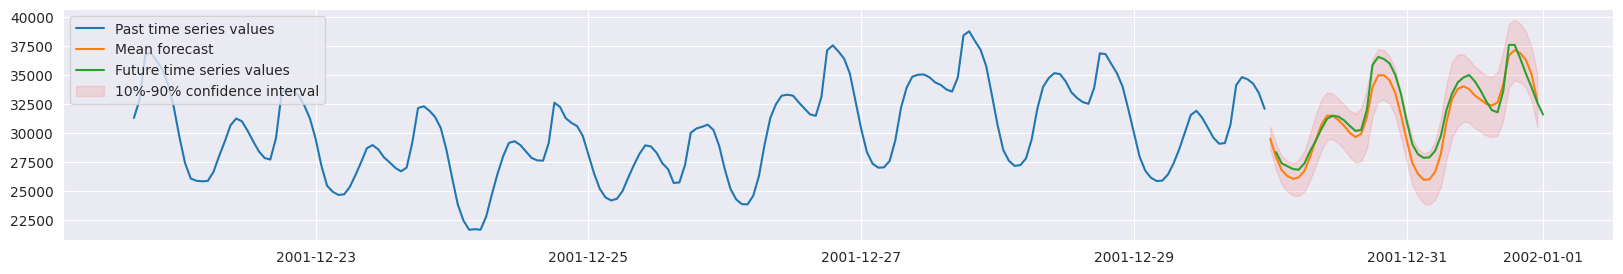

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style("darkgrid")
# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("/content/drive/MyDrive/Colab Data/AutoGluon/test_energy.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = fix_train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();